This is meant to be a newer analysis of my spectra to find the Mass of the SMBH in each quasar using $Mg _{II}$ according to the equation:
$$
M_{BH}(\text{Mg II}) = (6.79\cdot 10^6)(\frac{L(\text{Mg II})}{10^{42} \text{ erg s}^{-1}})^{0.62} (\frac{\text{FWHM(MgII)}}{10^3 \text{ km s}^{-1}})^{2} \text{ }M_\odot
$$

In [2]:
# Imports:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import peak_widths
from scipy.integrate import quadrature

- Show the spectra...


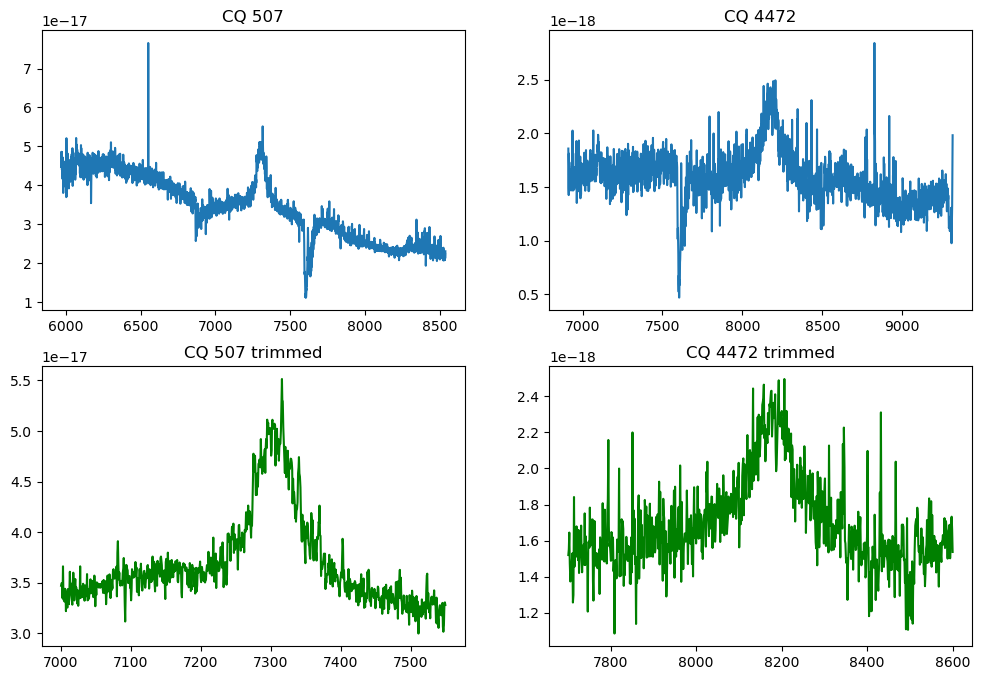

In [3]:
# Load data
CQ507 = np.loadtxt("CQ507.txt", delimiter=",")
CQ4472 = np.loadtxt("CQ4472.txt", delimiter=",")


# Plot initials
fig, axs = plt.subplots(2,2)

axs[0,0].plot(CQ507[:,0], CQ507[:,1])
axs[0,0].set_title("CQ 507")
axs[0,1].plot(CQ4472[:,0], CQ4472[:,1])
axs[0,1].set_title("CQ 4472")
# Trim data
CQ507 = CQ507[(CQ507[:,0] > 7000) & (CQ507[:,0] < 7550)]
CQ4472 = CQ4472[(CQ4472[:,0] > 7700) & (CQ4472[:,0] < 8600)]

# plot post trim
axs[1,0].plot(CQ507[:,0], CQ507[:,1], c="green")
axs[1,0].set_title("CQ 507 trimmed")
axs[1,1].plot(CQ4472[:,0], CQ4472[:,1], c="green")
axs[1,1].set_title("CQ 4472 trimmed")

fig.set_size_inches(12, 8)

plt.show()

I now want to redshift the data. The redshifts are quoted at:
$$
z = 
\begin{cases}
1.606   & \text{CQ 507} \\
1.921   & \text{CQ 4472}
\end{cases}
$$


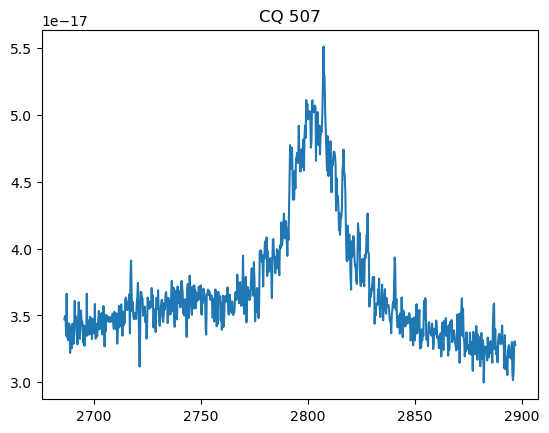

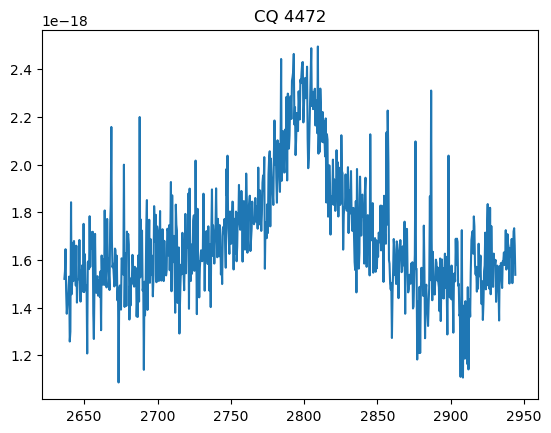

In [4]:
# Redshift the data:
def redshift(wls: list, z: float) -> list:
    """Redshift a given array according to the redshift z"""
    return wls / (z+1)

CQ507[:,0] = redshift(CQ507[:,0], 1.606)
CQ4472[:,0] = redshift(CQ4472[:,0], 1.921)

plt.plot(CQ507[:,0], CQ507[:,1])
plt.title("CQ 507")
plt.show()
plt.plot(CQ4472[:,0], CQ4472[:,1])
plt.title("CQ 4472")
plt.show()

Now, I want to fit two broad gaussians to the data. To do this, I want to use a best-fit regression function that will try and co-fit the data according to two differen Gaussians.

In [5]:
def gaus(x, a, m, o):
    return a*np.exp( -(x-m)**2 / (2*o**2))

def doubleGauss(x, A1,  m1, o1, A2, m2, o2):
    """
    Tries to fit two gaussians where H -> height above 0, A -> height of actual gaussian, m -> mean, o -> std dev
    """
    gaus1 = gaus(x, A1,  m1, o1)
    gaus2 = gaus(x, A2, m2, o2)

    return gaus1 + gaus2

Define a Gaussian iteration function which iteratively calls itself until a certain accuracy is met.

In [6]:
# Define
def IterativeDoubleGauss(x: list, y: list, g1: list, g2: list, n: float, a: float, n_c = 0):


    # Fit for both gaussians:
    fit, fiterror = curve_fit(doubleGauss, x, y, p0= [g for g in g1] + [g for g in g2], maxfev = 20000)

    # Find average residual error:
    residuals = [(y[i] - doubleGauss(x[i],*fit)) for i in range(len(x))]

    index_list = [] # list of bad points

    for i, r in enumerate(residuals):
        if (np.abs(np.mean(residuals) - r)/np.std(residuals)) >= a:
            # If residual is 3* std dev from avg residual, delete
            index_list.append(i)
    residuals = np.delete(residuals, index_list, axis=0)
    x = np.delete(np.array(x), index_list, axis=0)
    y = np.delete(np.array(y), index_list, axis=0)

    if len(x) == 0:

        print(f"Couldn't find optimal fit ater {n_c} iterations")
        return x, y, fit
    elif len(index_list) == 0:
        plt.plot(x, residuals, ".")
        plt.axhline(np.mean(residuals))
        plt.title(f"Residuals after {n_c} iterations")
        plt.show()
        plt.plot(x, y)
        plt.plot(x, gaus(x, fit[0], fit[1], fit[2]) + gaus(x, fit[3], fit[4], fit[5]))
        plt.title(f"Fit after {n_c} iterations where {len(x)} points remain")
        plt.show()
        return x, y, fit
    elif n_c == n:
        plt.plot(x, residuals, ".")
        plt.axhline(np.mean(residuals))
        plt.title(f"Residuals after {n_c} iterations")
        plt.show()
        plt.plot(x, y)
        plt.plot(x, gaus(x, fit[0], fit[1], fit[2]) + gaus(x, fit[3], fit[4], fit[5]))
        plt.title(f"Fit after {n_c} iterations where {len(x)} points remain")
        plt.show()
        print("Maximum number of iterations reached!")
        return  x, y, fit
    else:
     
        return IterativeDoubleGauss(x, y, [fit[0], fit[1], fit[2]], [fit[3], fit[4], fit[5]], n, a, n_c + 1)



Notes on fits below:

best (xshift, yshift)

- CQ 507:
    - (-2805, -33)
- CQ 4472:
    - (-2800, -1.6)

<font size = 6><h1 align=center>CQ4472 Fit</font>

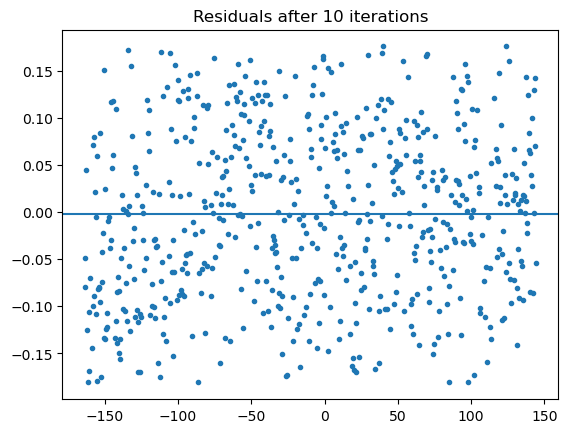

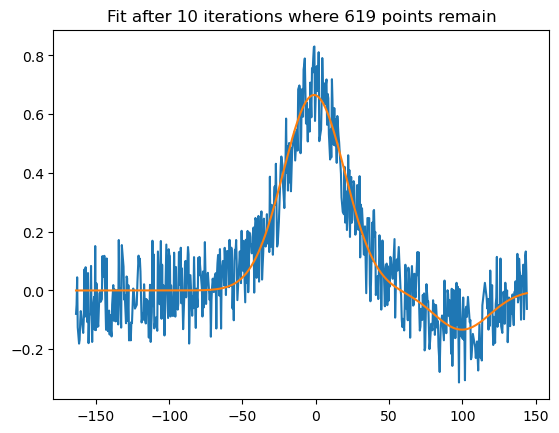

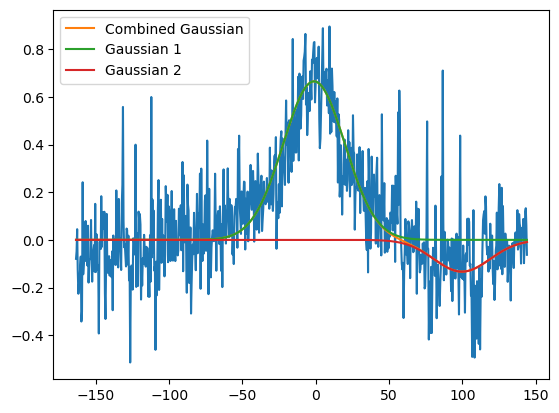

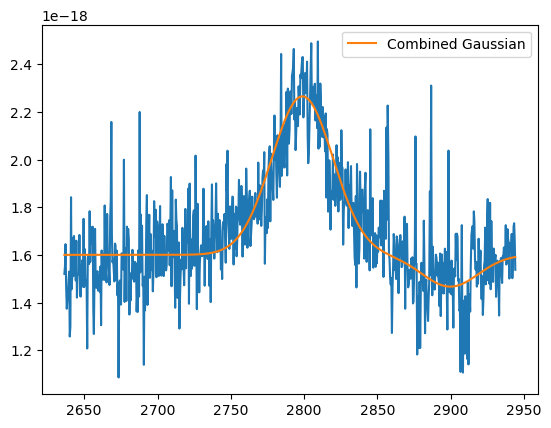

In [7]:
#### Test ####
x_4472 = np.copy(CQ4472[:,0]) - 2800
y_4472 = np.copy(CQ4472[:,1])*10e17 - 1.6


#### Params ####

ps = [np.max(y_4472) - np.min(y_4472), np.mean(x_4472), np.std(x_4472)]

x, y, f4472 = IterativeDoubleGauss(x_4472, y_4472, ps, ps, 15, 2)

# Plot 3
plt.plot(x_4472, y_4472)
plt.plot(x_4472, doubleGauss(x_4472,*f4472), label="Combined Gaussian")
plt.plot(x_4472, gaus(x_4472, *f4472[:3]), label="Gaussian 1")
plt.plot(x_4472, gaus(x_4472, *f4472[3:]), label = "Gaussian 2")
plt.legend()
plt.show()

#Plot 4
plt.plot(CQ4472[:,0], CQ4472[:,1])
plt.plot(CQ4472[:,0], 10e-19*(1.6+doubleGauss(x_4472,*f4472)), label="Combined Gaussian")
plt.legend()
plt.show()

7.062923352200019e-20
f 0.6653047766846971
FWHM = 5279.822505593469 km s^-1
L = 5.134492076259112e+43 erg s^-1
M = 2.1757894298951896
M-err = 0.050320596094402675


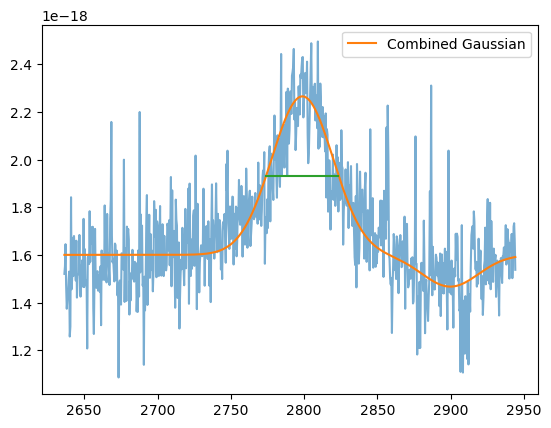

In [8]:
### Find Luminosity and FWHM
CQ4472_fit = 10e-19*(1.6+doubleGauss(x_4472,*f4472))        # Get fluxes

peak_ind = np.argmax(CQ4472_fit)    # Get index of the maximum
f_peak = CQ4472[:,0][peak_ind] * CQ4472_fit[peak_ind]

# Find FWHM
fwhm = peak_widths(CQ4472_fit, [peak_ind], rel_height=0.5)      # [indices]
sides = [fwhm[2][0], fwhm[3][0]]
h = fwhm[1][0]
fwhm = CQ4472[:,0][round(sides[1])] - CQ4472[:,0][round(sides[0])]   # [Angstrom]
c = 299792.458      # [km s^-1]

fwhm = c*fwhm /CQ4472[:,0][peak_ind]        # [km s^-1]

# L
z = 1.921   # redshift
H0 = 70     # [km s^-1 Mpc ^-1]
c = 299792.458  # [km s^-1]
d = (z*c/H0) * 3.08567758128e+24  # [cm]


L = 4*np.pi*d**2 * f_peak




# Errors:
def gaus4472(x): return 10e-19*(gaus(x, *f4472[:3]))
A = quadrature(gaus4472, x_4472[0], x_4472[-1]  )[0]
print(A)

k = 6.79e6
c = 1.064467

dM_dL = k*0.62/1e42 * (L/1e42)**-0.38*(fwhm/1e3)**2
dM_dF = 2*k/1e3 * (L/1e42)**0.62 * (fwhm/1e3)
sigL = 1/np.sqrt(np.shape(x_4472)[0])
curve_max = np.max(gaus(x_4472, *f4472[:3]))
print("f", curve_max)

sigF = np.sqrt(fwhm/(2*c*curve_max))
sigL = 1/np.sqrt(np.shape(x_4472)[0])
sigM = ((dM_dL*sigL)**2 + (dM_dF*sigF)**2)**0.5

# Print
print(f"FWHM = {fwhm} km s^-1")
print(f"L = {L} erg s^-1")

M = (6.79e6)*(L/1e42)**0.62 * (fwhm/1e3)**2
print(f"M = {M*1e-9}")
print(f"M-err = {sigM*1e-9}")

# Plot
plt.plot(CQ4472[:,0], CQ4472[:,1], alpha=0.6)
plt.plot(CQ4472[:,0], 10e-19*(1.6+doubleGauss(x_4472,*f4472)), label="Combined Gaussian")
plt.plot((CQ4472[:,0][round(sides[0])], CQ4472[:,0][round(sides[1])]), (h,h))
plt.legend()
plt.show()

<font size = 6><h1 align=center>CQ507 Fit</font>

(786,)


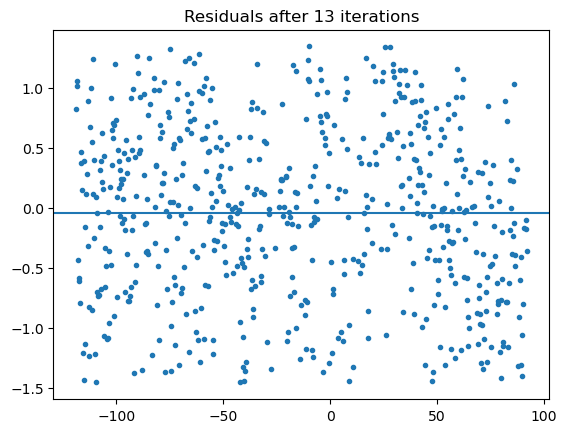

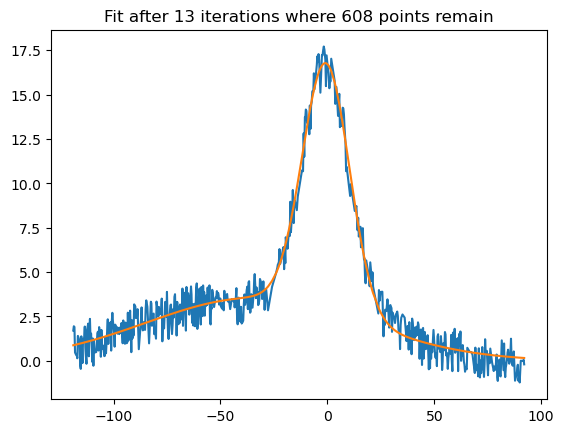

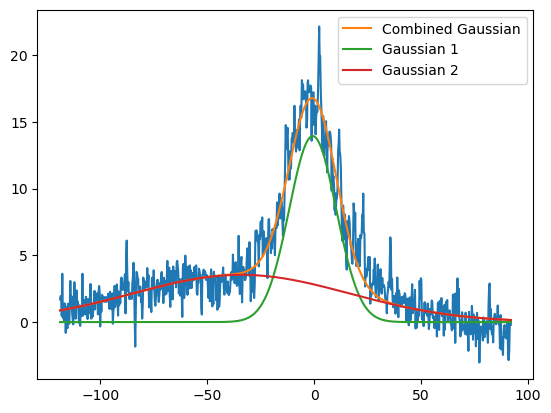

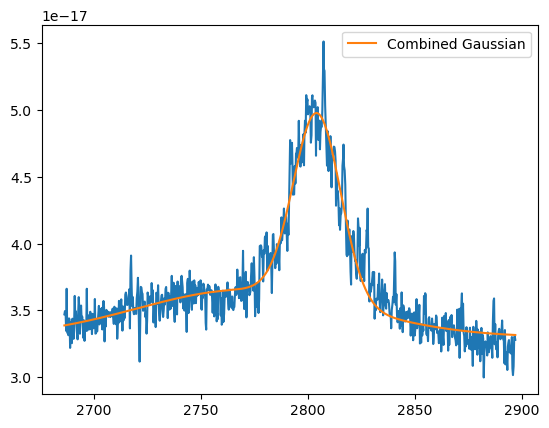

In [9]:
#### Test ####
x_507 = np.copy(CQ507[:,0])- 2805
y_507 = np.copy(CQ507[:,1])*10e17 - 33

print(np.shape(x_507))

#### Params ####

ps = [np.max(y_507) - np.min(y_507), np.mean(x_507), np.std(x_507)]

x, y, f507 = IterativeDoubleGauss(x_507, y_507, ps, ps, 15, 2)

# Plot 3
plt.plot(x_507, y_507)
plt.plot(x_507, doubleGauss(x_507,*f507), label="Combined Gaussian")
plt.plot(x_507, gaus(x_507, *f507[:3]), label="Gaussian 1")
plt.plot(x_507, gaus(x_507, *f507[3:]), label = "Gaussian 2")
plt.legend()
plt.show()

#Plot 4
plt.plot(CQ507[:,0], CQ507[:,1])
plt.plot(CQ507[:,0], 10e-19*(33+doubleGauss(x_507,*f507)), label="Combined Gaussian")
plt.legend()
plt.show()

f 13.928539801854038
FWHM = 3051.8893283548364 km s^-1
L = 7.900722229568722e+44 erg s^-1
M = 3.9587743469271173
M-err = 0.026319186345216312


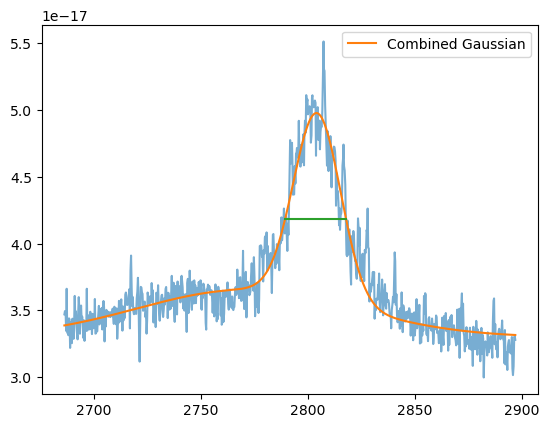

In [10]:
### Find Luminosity and FWHM
CQ507_fit = 10e-19*(33+doubleGauss(x_507,*f507))        # Get fluxes

peak_ind = np.argmax(CQ507_fit)    # Get index of the maximum
f_peak = CQ507[:,0][peak_ind] * CQ507_fit[peak_ind]

# Find FWHM
fwhm = peak_widths(CQ507_fit, [peak_ind], rel_height=0.5)      # [indices]
sides = [fwhm[2][0], fwhm[3][0]]
h = fwhm[1][0]
fwhm = CQ507[:,0][round(fwhm[3][0])] - CQ507[:,0][round(fwhm[2][0])]   # [Angstrom]
c = 299792.458      # [km s^-1]

fwhm = c*fwhm /CQ507[:,0][peak_ind]        # [km s^-1]

# L
z = 1.606   # redshift
H0 = 70     # [km s^-1 Mpc ^-1]
c = 299792.458  # [km s^-1]
d = (z*c/H0) * 3.08567758128e+24  # [cm]

L = 4*np.pi*d**2 * f_peak

# Errors
k = 6.79e6
c = 1.064467

dM_dL = k*0.62/1e42 * (L/1e42)**-0.38*(fwhm/1e3)**2
dM_dF = 2*k/1e3 * (L/1e42)**0.62 * (fwhm/1e3)
sigL = 1/np.sqrt(np.shape(x_507)[0])
curve_max = np.max(gaus(x_507, *f507[:3]))
print("f", curve_max)

sigF = np.sqrt(fwhm/(2*c*curve_max))
sigL = 1/np.sqrt(np.shape(x_507)[0])
sigM = ((dM_dL*sigL)**2 + (dM_dF*sigF)**2)**0.5



# Print
print(f"FWHM = {fwhm} km s^-1")
print(f"L = {L} erg s^-1")

M = (6.79e6)*(L/1e42)**0.62 * (fwhm/1e3)**2
print(f"M = {M*1e-9}")
print(f"M-err = {sigM*1e-9}")

# Plot
plt.plot(CQ507[:,0], CQ507[:,1], alpha=0.6)
plt.plot(CQ507[:,0], 10e-19*(33+doubleGauss(x_507,*f507)), label="Combined Gaussian")
plt.plot((CQ507[:,0][round(sides[0])], CQ507[:,0][round(sides[1])]), (h,h))
plt.legend()
plt.show()